## 1. Import Library yang Dibutuhkan

In [ ]:
import sklearn

In [ ]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# Corrected the typo here
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import datetime
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt_tab')
nltk.download('stopwords')
import re

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Memuat df

In [ ]:
df = pd.read_csv('tweets_perkembangan_ai_60bulan.csv')

print(f"Jumlah df: {df.shape[0]} baris dan {df.shape[1]} kolom")
df.head()

Jumlah df: 5354 baris dan 1 kolom


Tweet
0  aiinstitute.id\n@aiinstituteid\n·\nMay 9\nSala...
1  GTN\n@Gtid_news\n·\nApr 29\nPendiri Lippo Grou...
2  Kementerian Digital Malaysia\n@kemdigital_gov\...
3  Asisten AI\n@AsistenAI\n·\nApr 18\nAutomated\n...
4  MeonameoN\n@MOUNT_EATER\n·\n11h\nDigital twin ...

## 3.  Parsing Tanggal & Preprocessing

In [ ]:
import pandas as pd
import re
import csv
from datetime import datetime


def extract_info_from_tweet(tweet_text):
    username_pattern = r'@([A-Za-z0-9_]+)'
    username_match = re.search(username_pattern, tweet_text)
    username = username_match.group(1) if username_match else "Unknown"


    content = ""
    date_line_pattern = r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2}'
    date_line_match = re.search(date_line_pattern, tweet_text)

    if date_line_match:
        date_line_pos = date_line_match.end()
        lines = tweet_text[date_line_pos:].strip().split('\n')
        if lines and len(lines) > 0:
            content = '\n'.join(lines).strip()
    else:

        if username_match:
            username_pos = username_match.end()
            content = tweet_text[username_pos:].strip()
        else:
            content = tweet_text.strip()


    date_patterns = [
        r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+(\d{1,2})(?:,?\s+(\d{4}))?',
        r'(\d{1,2})\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\s+(\d{4}))?'
    ]


    numeric_date_pattern = r'(\d{1,2})[/-](\d{1,2})[/-](\d{4})'

    months = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }


    for pattern in date_patterns:
        matches = re.finditer(pattern, tweet_text)
        for match in matches:
            try:
                if len(match.groups()) >= 2 and match.group(2):

                    month_str = re.search(r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', match.group(0)).group(0)
                    month = months.get(month_str, 1)
                    day = int(match.group(1))
                    year = int(match.group(2))


                    if 1 <= day <= 31 and 2020 <= year <= 2025:
                        return datetime(year, month, day), username, content
                else:

                    month_str = re.search(r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', match.group(0)).group(0)
                    month = months.get(month_str, 1)
                    day = int(match.group(1))


                    year_match = re.search(r'\b(202[0-5])\b', tweet_text)
                    if year_match:
                        year = int(year_match.group(1))
                    else:

                        current_year = 2025
                        current_month = datetime.now().month


                        if month > current_month:
                            year = current_year - 1
                        else:
                            year = current_year


                    if 1 <= day <= 31 and 2020 <= year <= 2025:
                        return datetime(year, month, day), username, content
            except (ValueError, AttributeError):
                continue


    numeric_match = re.search(numeric_date_pattern, tweet_text)
    if numeric_match:
        try:

            day = int(numeric_match.group(1))
            month = int(numeric_match.group(2))
            year = int(numeric_match.group(3))


            if 1 <= day <= 31 and 1 <= month <= 12 and 2020 <= year <= 2025:
                return datetime(year, month, day), username, content
        except ValueError:
            pass


    year_match = re.search(r'\b(202[0-5])\b', tweet_text)
    if year_match:
        year = int(year_match.group(1))
        return datetime(year, 1, 1), username, content


    return datetime(2025, 1, 1), username, content


tweets_df = []
with open('tweets_perkembangan_ai_60bulan.csv', 'r', encoding='utf-8') as file:
    next(file)

    content = file.read()

    tweets = content.split('"\n"')

    if tweets and tweets[0].startswith('"'):
        tweets[0] = tweets[0][1:]

    if tweets and tweets[-1].endswith('"'):
        tweets[-1] = tweets[-1][:-1]

    for i, tweet in enumerate(tweets):
        if tweet.strip():
            date, username, content = extract_info_from_tweet(tweet)
            tweets_df.append({
                'tweet_id': i + 1,
                'username': username,
                'content': content,
                'tweet_text': tweet.strip(),
                'date': date,
                'year': date.year,
                'month': date.month,
                'day': date.day
            })

df = pd.DataFrame(tweets_df)
df_sorted = df.sort_values(by='date', ascending=False)
df_sorted['formatted_date'] = df_sorted['date'].dt.strftime('%Y-%m-%d')
df.drop(columns=['tweet_text','username','tweet_id'], inplace=True)


print(f"Total tweets: {len(df_sorted)}")
print("\nDistribusi tweet berdasarkan tahun (mundur dari 2025-2020):")
year_counts = df_sorted['year'].value_counts().sort_index(ascending=False)
for year, count in year_counts.items():
    if 2020 <= year <= 2025:
        print(f"Tahun {year}: {count} tweets")
# df.head()
df.to_csv("df_baru.csv")

Total tweets: 5366

Distribusi tweet berdasarkan tahun (mundur dari 2025-2020):
Tahun 2025: 563 tweets
Tahun 2024: 1226 tweets
Tahun 2023: 1219 tweets
Tahun 2022: 1064 tweets
Tahun 2021: 970 tweets
Tahun 2020: 324 tweets


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5366 entries, 0 to 5365
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   content  5366 non-null   object        
 1   date     5366 non-null   datetime64[ns]
 2   year     5366 non-null   int64         
 3   month    5366 non-null   int64         
 4   day      5366 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 209.7+ KB


In [ ]:
df.isnull().sum()
df['content'] = df['content'].fillna('').astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5366 entries, 0 to 5365
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   content  5366 non-null   object        
 1   date     5366 non-null   datetime64[ns]
 2   year     5366 non-null   int64         
 3   month    5366 non-null   int64         
 4   day      5366 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 209.7+ KB


In [ ]:
df = df[
    df['content'].str.lower().str.contains('perkembangan') &
    df['content'].str.lower().str.contains('ai')
]

print(df.shape)

df.to_csv('filtered_df.csv')

(1595, 5)


## Preprocessing

In [ ]:
def tokenize(text):
    # Hapus tanda baca (kecuali angka & huruf)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Lowercase & split
    tokens = text.lower().split()
    return tokens
tokens= df['tokens']=df['content'].apply(tokenize)
tokens.head()

1    [pendiri, lippo, group, mochtar, riady, menyeb...
2    [penang, ai, city, meneraju, transformasi, ban...
3    [automated, gue, merasa, kita, sekarang, berad...
4    [11h, digital, twin, expertise, melihat, perke...
5    [dalam, pertemuan, dengan, jack, azagury, dari...
Name: content, dtype: object

## Normalisasi

In [ ]:
import pandas as pd

# Baca kedua file CSV
kamus1 = pd.read_csv('colloquial-indonesian-lexicon.csv')
kamus2 = pd.read_csv('normalisasi.csv')

# Samakan nama kolom
kamus1 = kamus1.rename(columns={'slang': 'alay', 'formal': 'formal'})
kamus2 = kamus2.rename(columns={'alay': 'alay', 'normal': 'formal'})

# Gabungkan dua kamus
kamus_gabungan = pd.concat([kamus1, kamus2], ignore_index=True)
kamus_gabungan.drop_duplicates(subset='alay', inplace=True)

# Buat dictionary normalisasi
alay_dict = dict(zip(kamus_gabungan['alay'], kamus_gabungan['formal']))

# Fungsi normalisasi
def normalize_text(token_list):
    if not isinstance(token_list, list) or not token_list:
        return []

    normalized_tokens = []
    for token in token_list:
        if not isinstance(token, str):
            normalized_tokens.append(str(token))
            continue
        normalized_token = alay_dict.get(token.lower(), token)
        if normalized_token:
            normalized_tokens.append(normalized_token)
    return normalized_tokens

df['normalized'] = tokens.apply(normalize_text)

# df.to_csv('df_baru.csv')


In [ ]:
df

content       date  year  \
1     Pendiri Lippo Group, Mochtar Riady, menyebut s... 2025-04-29  2025   
2     PENANG AI CITY MENERAJU TRANSFORMASI BANDAR PI... 2025-04-28  2025   
3     Automated\nGue merasa kita sekarang berada di ... 2025-04-18  2025   
4     ·\n11h\nDigital twin expertise.\n\nMelihat per... 2025-01-01  2025   
5     Dalam pertemuan dengan Jack Azagury dari Accen... 2025-04-29  2025   
...                                                 ...        ...   ...   
5352  , 2020\nhttps://anchor.fm/GPC/episodes/Eps--01... 2020-06-24  2020   
5355  , 2020\nReplying to \n@blueprintlmrn\nSelain a... 2020-06-30  2020   
5356  , 2020\nReplying to \n@faiqrifqi_\nMungkin ke ... 2020-06-25  2020   
5359  , 2020\nReplying to \n@SuaraKlik\nDengan perke... 2020-06-19  2020   
5360  , 2020\nBerbahasa saat menyampaikan ide dan pi... 2020-07-09  2020   

      month  day                                             tokens  \
1         4   29  [pendiri, lippo, group, mochtar, riady, menyeb...   
2         4   28  [penang, ai, city, meneraju, transformasi, ban...   
3         4   18  [automated, gue, merasa, kita, sekarang, berad...   
4         1    1  [11h, digital, twin, expertise, melihat, perke...   
5         4   29  [dalam, pertemuan, dengan, jack, azagury, dari...   
...     ...  ...                                                ...   
5352      6   24  [2020, https, anchor, fm, gpc, episodes, eps, ...   
5355      6   30  [2020, replying, to, blueprintlmrn, selain, al...   
5356      6   25  [2020, replying, to, faiqrifqi_, mungkin, ke, ...   
5359      6   19  [2020, replying, to, suaraklik, dengan, perkem...   
5360      7    9  [2020, berbahasa, saat, menyampaikan, ide, dan...   

                                             normalized  
1     [pendiri, lippo, group, mochtar, riady, menyeb...  
2     [penang, ai, city, meneraju, transformasi, ban...  
3     [automated, gue, merasa, kita, sekarang, berad...  
4     [11h, digital, twin, expertise, melihat, perke...  
5     [dalam, pertemuan, dengan, jack, azagury, dari...  
...                                                 ...  
5352  [2020, https, anchor, fm, gpc, episodes, eps, ...  
5355  [2020, replying, tapi, blueprintlmrn, selain, ...  
5356  [2020, replying, tapi, faiqrifqi_, mungkin, ke...  
5359  [2020, replying, tapi, suaraklik, dengan, perk...  
5360  [2020, berbahasa, saat, menyampaikan, ide, dan...  

[1595 rows x 7 columns]

# REGEX

In [ ]:
# Fungsi untuk preprocessing teks
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['regex'] = df['content'].apply(preprocess_text)
df['regex'].head()


1    pendiri lippo group mochtar riady menyebut sek...
2    penang ai city meneraju transformasi bandar pi...
3    automated gue merasa kita sekarang berada di e...
4    h digital twin expertise melihat perkembangan ...
5    dalam pertemuan dengan jack azagury dari accen...
Name: regex, dtype: object

## ***Case folding***

In [ ]:
import re

def case_folding(df, text_field, new_text_field_name):
    # Pastikan nilai kosong tidak menyebabkan error
    df[text_field] = df[text_field].fillna('').astype(str)
    df[new_text_field_name] = df[text_field].str.lower()



# Panggil fungsi dengan parameter yang benar
case_folding(df, 'content', 'regex')
case_folding=df['regex']
# Tampilkan hasil
case_folding.head()


1    pendiri lippo group, mochtar riady, menyebut s...
2    penang ai city meneraju transformasi bandar pi...
3    automated\ngue merasa kita sekarang berada di ...
4    ·\n11h\ndigital twin expertise.\n\nmelihat per...
5    dalam pertemuan dengan jack azagury dari accen...
Name: regex, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1595 entries, 1 to 5360
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   content     1595 non-null   object        
 1   date        1595 non-null   datetime64[ns]
 2   year        1595 non-null   int64         
 3   month       1595 non-null   int64         
 4   day         1595 non-null   int64         
 5   tokens      1595 non-null   object        
 6   normalized  1595 non-null   object        
 7   regex       1595 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 112.1+ KB


# Translated

In [ ]:
!pip install deep_translator

In [ ]:
from deep_translator import GoogleTranslator
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Misal df sudah tersedia dan kolomnya bernama 'regex'

# Translator: Asumsi awal adalah datanya mungkin campuran, jadi kita terjemahkan ke Inggris dulu
to_indonesian = GoogleTranslator(source='en', target='id')

# Fungsi terjemahkan dari Inggris ke Indonesia
def translate_to_indonesian(text):
    try:
        return to_indonesian.translate(text)
    except:
        return "ERR"

# Proses dua tahap dengan progress bar
df['indonesian'] = df['regex'].progress_apply(translate_to_indonesian)
translated=df['indonesian']
# Lihat hasil 5 baris pertama
print(df.head())




In [ ]:
df

df.to_csv('translated.csv')

## Stopword

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
df=pd.read_csv('translated.csv')
df.head()

Unnamed: 0                                            content        date  \
0           1  Pendiri Lippo Group, Mochtar Riady, menyebut s...  2025-04-29   
1           2  PENANG AI CITY MENERAJU TRANSFORMASI BANDAR PI...  2025-04-28   
2           3  Automated\nGue merasa kita sekarang berada di ...  2025-04-18   
3           4  ·\n11h\nDigital twin expertise.\n\nMelihat per...  2025-01-01   
4           5  Dalam pertemuan dengan Jack Azagury dari Accen...  2025-04-29   

   year  month  day                                             tokens  \
0  2025      4   29  ['pendiri', 'lippo', 'group', 'mochtar', 'riad...   
1  2025      4   28  ['penang', 'ai', 'city', 'meneraju', 'transfor...   
2  2025      4   18  ['automated', 'gue', 'merasa', 'kita', 'sekara...   
3  2025      1    1  ['11h', 'digital', 'twin', 'expertise', 'melih...   
4  2025      4   29  ['dalam', 'pertemuan', 'dengan', 'jack', 'azag...   

                                          normalized  \
0  ['pendiri', 'lippo', 'group', 'mochtar', 'riad...   
1  ['penang', 'ai', 'city', 'meneraju', 'transfor...   
2  ['automated', 'gue', 'merasa', 'kita', 'sekara...   
3  ['11h', 'digital', 'twin', 'expertise', 'melih...   
4  ['dalam', 'pertemuan', 'dengan', 'jack', 'azag...   

                                               regex  
0  pendiri lippo group, mochtar riady, menyebut s...  
1  penang ai city meneraju transformasi bandar pi...  
2  automated\ngue merasa kita sekarang berada di ...  
3  ·\n11h\ndigital twin expertise.\n\nmelihat per...  
4  dalam pertemuan dengan jack azagury dari accen...

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import pandas as pd

# Ensure stopwords are downloaded
# This line was moved here to guarantee the resource is available
nltk.download('stopwords')

# Stopword bawaan + tambahan
stop_words = set(stopwords.words('indonesian'))
additional_stopwords = {
    'yang', 'dengan', 'dan', 'di', 'ke', 'dari', 'untuk', 'pada', 'adalah', 'ini', 'itu',
    'atau', 'juga', 'saya', 'kamu', 'dia', 'mereka', 'kita', 'kami', 'akan', 'sudah', 'telah',
    'sedang', 'belum', 'tidak', 'bukan', 'tapi', 'namun', 'melainkan', 'karena', 'sebab',
    'oleh', 'jika', 'kalau', 'bila', 'ketika', 'saat', 'waktu', 'selama', 'setelah', 'sebelum',
    'sejak', 'hingga', 'sampai', 'tentang', 'mengenai', 'terhadap', 'kepada', 'bagi', 'sebagai',
    'seperti', 'secara', 'dalam', 'luar', 'atas', 'bawah', 'antara', 'sekitar', 'melalui',
    'meski', 'walaupun', 'seandainya', 'supaya', 'agar', 'sehingga', 'maka', 'lalu', 'kemudian',
    'selanjutnya', 'sebaliknya', 'bahkan', 'apalagi', 'selain', 'hanya', 'saja', 'pun', 'lagi',
    'bahwa', 'merupakan', 'ada', 'dapat', 'bisa', 'mungkin', 'rasanya', 'terasa', 'jadi',
    'terjadi', 'menjadi', 'begitu', 'demikian', 'sangat', 'amat', 'sekali', 'paling', 'lebih',
    'kurang', 'makin', 'semakin', 'lagi', 'masih', 'selalu', 'terus', 'sering', 'jarang',
    'tak', 'tiada', 'tanpa', 'bukanlah', 'jangan', 'ya', 'oh', 'ah', 'wah', 'eh', 'hai',
    'halo', 'loh', 'lah', 'dong', 'sih', 'kan', 'deh', 'nih', 'tuh', 'mah', 'nya', 'si',
    'orang', 'manusia', 'apa', 'dimulai', 'mengawali', 'mengakhiri', 'menyelesaikan',
    'menuntaskan', 'membereskan', 'show', 'more'
}
stop_words.update(additional_stopwords)

def stopwords(text):
    if pd.isnull(text):
        return ""
    tokens = word_tokenize(str(text).lower())
    return [word for word in tokens if word not in stop_words]

df['stopword'] = df['indonesian'].apply(stopwords)
stopword=df['stopword']
stopword.head()

stow=df['stopword']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyError: 'indonesian'

# stemming

In [ ]:
!pip install Sastrawi
!pip install tqdm

In [ ]:
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
tqdm.pandas()

# Inisialisasi stemmer
factory = StemmerFactory()
sastrawi_stemmer = factory.create_stemmer()

# Fungsi stemming
def apply_stemming(text):
    return [sastrawi_stemmer.stem(word) for word in text]

# Asumsikan kolom 'stopword' berisi list token
data['stemming'] = df['stopword'].progress_apply(apply_stemming)

# Simpan ke variabel terpisah (opsional)
stemming = data['stemming']


In [ ]:
stemming.to_csv('df_prep.csv')
prep=pd.read_csv('df_prep.csv')
prep.head()

In [ ]:
prep =pd.read_csv('df_prep.csv')
prep.head()

In [ ]:
# Buat DataFrame baru yang berisi dua kolom dari dua DataFrame terpisah
gabungan = pd.DataFrame({
    'stemming': prep['stemming'].values,
    'date': df['date'].values,
    'year': df['year'].values,
    'month': df['month'].values,
    'day': df['day'].values,
})


In [ ]:
gabungan.to_csv('gabungan.csv')

NameError: name 'gabungan' is not defined

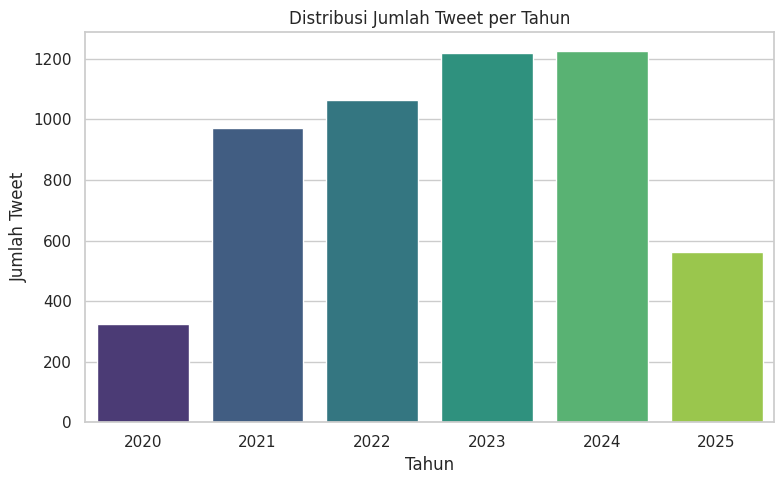

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
year_counts = df_sorted['year'].value_counts().sort_index()



plt.figure(figsize=(8,5))
sns.barplot(x=year_counts.index, y=year_counts.values, palette='viridis')

plt.title('Distribusi Jumlah Tweet per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 4. Preprocessing Teks untuk Analisis Sentimen

In [ ]:
# Fungsi untuk preprocessing teks
def preprocess_text(token_list):
    # Check if the input is a list and join it into a string, otherwise handle non-string inputs
    if isinstance(token_list, list):
        text = ' '.join(map(str, token_list)) # Join list elements into a string, ensuring they are strings
    elif pd.isna(token_list) or token_list is None:
        return "" # Handle NaN or None values
    else:
        text = str(token_list) # Convert other types to string

    # Mengubah ke lowercase
    text = text.lower()

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Menghapus username Twitter
    text = re.sub(r'@\w+', '', text)

    # Menghapus hashtag
    text = re.sub(r'#\w+', '', text)

    # Menghapus karakter non-alfanumerik
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    # Menghapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Menerapkan preprocessing pada konten yang sudah dibersihkan (kolom 'stemming' yang berisi list)
# Akan menggabungkan list menjadi string lalu menerapkan preprocessing
df['regex2'] = df['stemming'].apply(preprocess_text)

# Tampilkan beberapa baris pertama dari kolom baru untuk verifikasi
print(df['regex2'].head())\



KeyError: 'stemming'

## Ekstrasi Fitur

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import PCA
import pandas as pd # Pastikan pandas diimpor jika belum

# Asumsi data['stemming'] sudah dibersihkan dan berisi list of tokens

# Gabungkan list token menjadi string untuk setiap dokumen
# Handle kasus jika ada baris yang kosong atau non-list
corpus = [' '.join(map(str, doc)) if isinstance(doc, list) else '' for doc in data['stemming']]


# --- 1. Count Vectorizer ---
count_vect = CountVectorizer()
X_count = count_vect.fit_transform(corpus)
print("CountVectorizer shape:", X_count.shape)

# --- 2. TF-IDF Vectorizer (langsung) ---
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(corpus)
print("TfidfVectorizer shape:", X_tfidf.shape)

# --- 3. TF-IDF Transformer (berbasis CountVectorizer) ---
# CountVectorizer juga perlu input list of strings
count_vect2 = CountVectorizer()
X_count2 = count_vect2.fit_transform(corpus)


# --- 4. Hashing Vectorizer ---
hash_vect = HashingVectorizer(n_features=1000)  # Atur jumlah fitur sesuai kebutuhan
X_hash = hash_vect.transform(corpus) # transform karena sudah fit di CountVectorizer atau TfidfVectorizer
print("HashingVectorizer shape:", X_hash.shape)

# --- (Optional) PCA untuk reduksi dimensi ---
# PCA hanya bisa untuk dense matrix, jadi kita convert dulu
X_dense = X_tfidf.toarray()

pca = PCA(n_components=2)  # Misalnya ingin reduksi ke 2 dimensi
X_pca = pca.fit_transform(X_dense)
print("PCA result shape:", X_pca.shape)

Modelling

### **LABELLING**

## 5. Labelling Emosi

## 9. Analisis Korelasi Antar Emosi

## 5. Pemodelan Sentimen & Emosi (Tanpa Deep Learning)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. LOAD DATA
# ---------------------------
df_train = pd.read_csv("/content/predicted_label_dataset_balanced.csv")  # kolom: ['text', 'label']
df_target = pd.read_csv("translated.csv")  # kolom: ['regex']

# ---------------------------
# 2. FEATURE EXTRACTION
# ---------------------------
def extract_features(text_series, vectorizer=None, fit_vectorizer=False):
    if fit_vectorizer:
        vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)
        bow = vectorizer.fit_transform(text_series).toarray()
    else:
        bow = vectorizer.transform(text_series).toarray()

    bow_df = pd.DataFrame(bow, columns=vectorizer.get_feature_names_out())

    sentiment = text_series.apply(lambda x: TextBlob(x).sentiment if x else (0, 0))
    polarity = [s[0] for s in sentiment]
    subjectivity = [s[1] for s in sentiment]
    sentiment_df = pd.DataFrame({'polarity': polarity, 'subjectivity': subjectivity})

    stats_df = pd.DataFrame()
    stats_df['char_count'] = text_series.apply(lambda x: len(str(x)))
    stats_df['word_count'] = text_series.apply(lambda x: len(str(x).split()))
    stats_df['avg_word_len'] = text_series.apply(lambda x: np.mean([len(w) for w in str(x).split()]) if x else 0)

    return pd.concat([bow_df, sentiment_df, stats_df], axis=1), vectorizer

# ---------------------------
# 3. EKSTRAKSI FITUR
# ---------------------------
X_train, vectorizer = extract_features(df_train['text'], fit_vectorizer=True)
y_train = df_train['label']

X_target, _ = extract_features(df_target['regex'], vectorizer=vectorizer, fit_vectorizer=False)

# GaussianNB memerlukan fitur non-negatif: normalisasi standar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_target_scaled = scaler.transform(X_target)

# ---------------------------
# 4. MODEL DEFINISI
# ---------------------------
models = {
    'GaussianNB': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),

}

# ---------------------------
# 5. TRAINING & PREDIKSI
# ---------------------------
for name, model in models.items():
    print(f"🔁 Melatih model: {name}")
    if name == 'GaussianNB':
        model.fit(X_train_scaled, y_train)
        predicted = model.predict(X_target_scaled)
    else:
        model.fit(X_train, y_train)
        predicted = model.predict(X_target)

    result_df = df_target.copy()
    result_df['predicted_label'] = predicted
    filename = f"hasil_labeling_{name}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Model {name} selesai. Hasil disimpan di: {filename}")



🔁 Melatih model: GaussianNB
✅ Model GaussianNB selesai. Hasil disimpan di: hasil_labeling_GaussianNB.csv
🔁 Melatih model: MLP
✅ Model MLP selesai. Hasil disimpan di: hasil_labeling_MLP.csv


In [ ]:
import os

# List nama file hasil labeling
result_files = [
    "hasil_labeling_GaussianNB.csv",
    "hasil_labeling_MLP.csv",

]

# Tampilkan value_counts untuk masing-masing hasil
for file in result_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        print(f"\n📊 Value Counts - {file}")
        print(df['predicted_label'].value_counts())
    else:
        print(f"⚠️ File tidak ditemukan: {file}")



📊 Value Counts - hasil_labeling_GaussianNB.csv
predicted_label
fear       382
neutral    305
joy        282
love       279
sadness    216
anger      131
Name: count, dtype: int64

📊 Value Counts - hasil_labeling_MLP.csv
predicted_label
neutral    729
joy        440
anger      161
sadness    125
love        93
fear        47
Name: count, dtype: int64


## 6. Evaluasi Model


📊 Evaluasi model: GaussianNB
Akurasi: 0.5270
Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.38      0.53      1000
        fear       0.37      1.00      0.54      1000
         joy       0.71      0.43      0.54      1000
        love       0.60      0.67      0.63      1000
     neutral       0.84      0.21      0.33      1000
     sadness       0.51      0.47      0.49      1000

    accuracy                           0.53      6000
   macro avg       0.65      0.53      0.51      6000
weighted avg       0.65      0.53      0.51      6000

Confusion Matrix:
[[384 301  39  35  15 226]
 [  0 996   0   1   1   2]
 [  6 230 432 253  12  67]
 [  2 298   8 670   2  20]
 [ 52 376 117 112 209 134]
 [  1 462  15  41  10 471]]

📊 Evaluasi model: MLP
Akurasi: 0.9932
Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.99      1.00      1000
        fear       1.00      1.00   

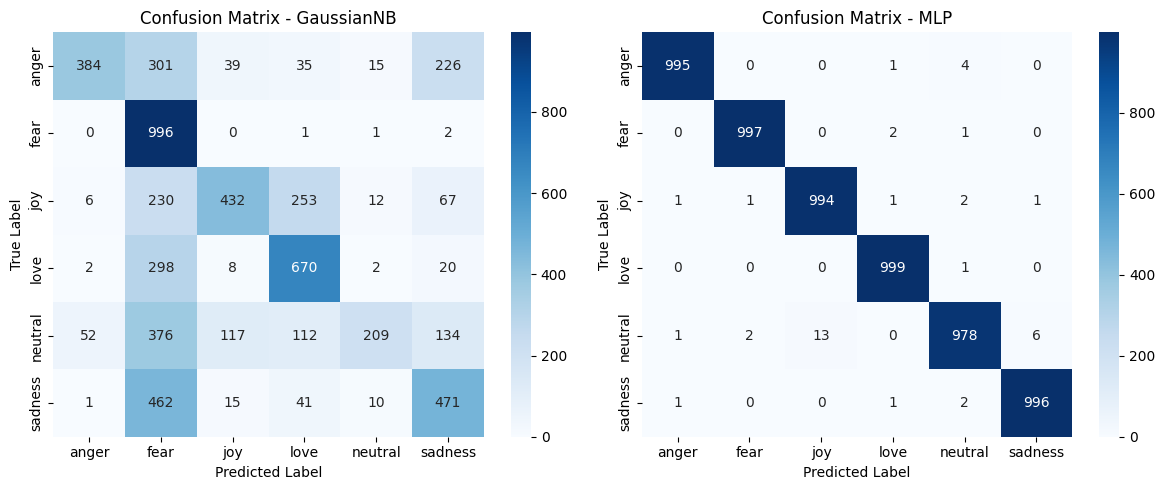

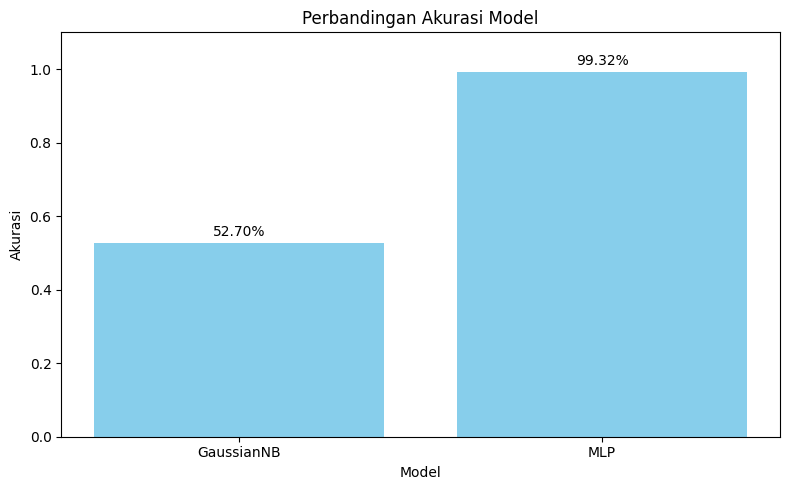

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 6. EVALUASI MODEL DENGAN TRAINING DATA (SEBAGAI SIMULASI)
# ---------------------------

eval_results = []
label_kelas = sorted(df_train['label'].unique())

for name, model in models.items():
    print(f"\n📊 Evaluasi model: {name}")
    try:
        # Prediksi ulang di training set (simulasi evaluasi jika tidak ada test set)
        if name == 'GaussianNB':
            y_pred_train = model.predict(X_train_scaled)
        else:
            y_pred_train = model.predict(X_train)

        acc = accuracy_score(y_train, y_pred_train)
        cm = confusion_matrix(y_train, y_pred_train, labels=label_kelas)

        print(f"Akurasi: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_train, y_pred_train))
        print("Confusion Matrix:")
        print(cm)

        eval_results.append((name, acc, cm))

    except Exception as e:
        print(f"Gagal evaluasi {name}: {e}")

# ---------------------------
# 7. PLOTTING CONFUSION MATRIX
# ---------------------------
fig, axes = plt.subplots(1, len(eval_results), figsize=(6 * len(eval_results), 5))
axes = np.atleast_1d(axes)

for ax, (name, _, cm) in zip(axes, eval_results):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_kelas, yticklabels=label_kelas)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

# ---------------------------
# 8. PERBANDINGAN AKURASI MODEL
# ---------------------------
plt.figure(figsize=(8, 5))
model_names = [name for name, _, _ in eval_results]
accuracies = [acc for _, acc, _ in eval_results]

bars = plt.bar(model_names, accuracies, color='skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.01,
             f'{bar.get_height():.2%}', ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.title("Perbandingan Akurasi Model")
plt.xlabel("Model")
plt.ylabel("Akurasi")
plt.tight_layout()
plt.show()


## 8. Analisis Kata-kata yang Sering Muncul Berdasarkan Emosi

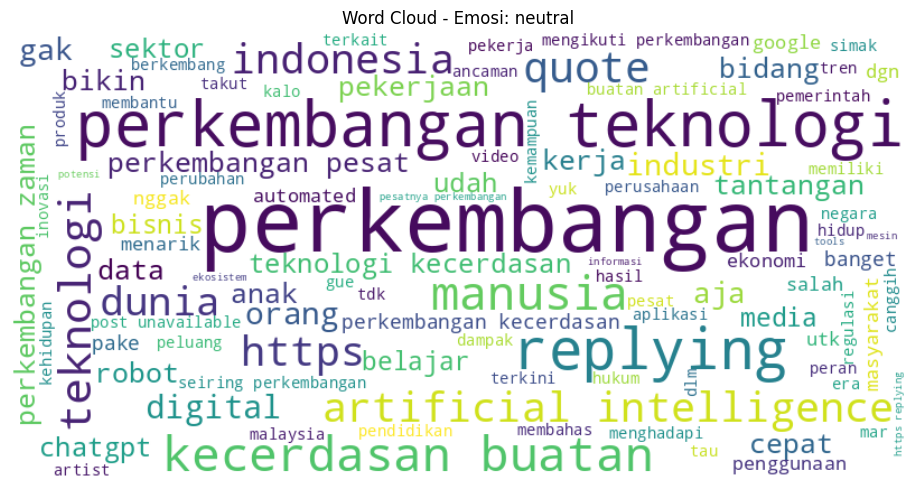

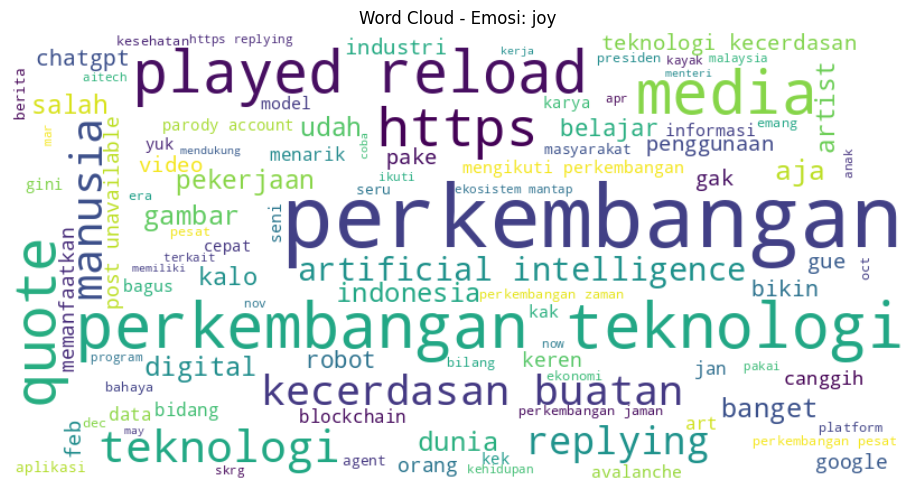

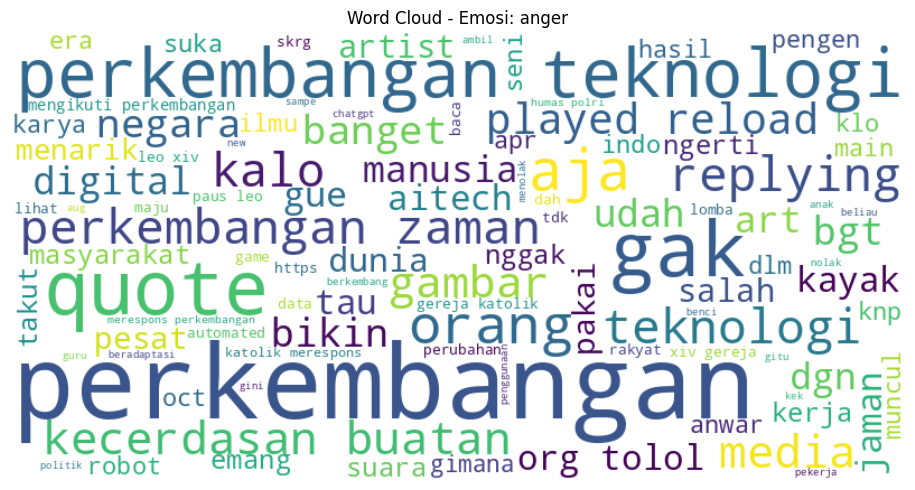

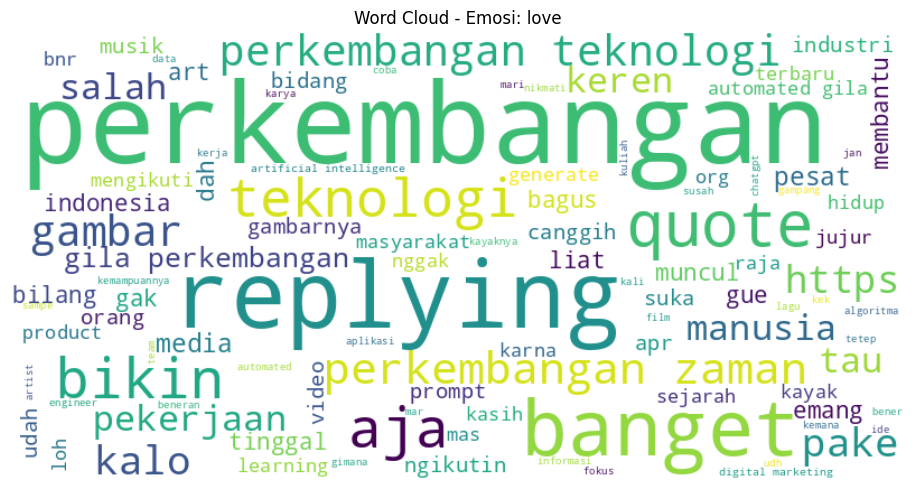

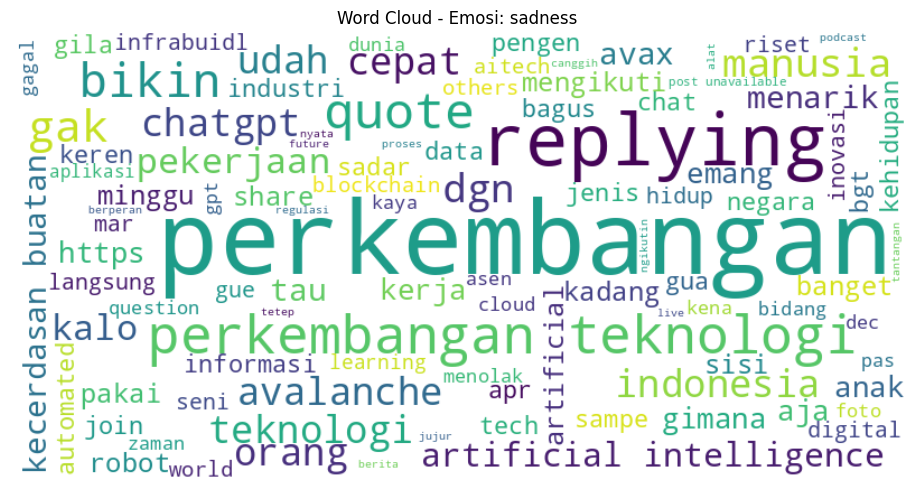

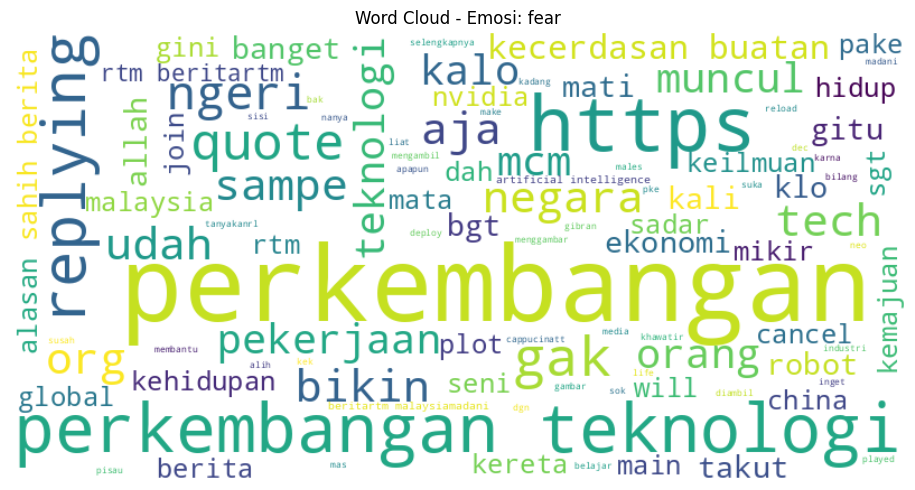

In [ ]:



df=pd.read_csv("hasil_labeling_MLP.csv")

stop_words = set(stopwords.words('indonesian'))
additional_stopwords = {
    'show', 'more', 'nya', 'kan', 'sih', 'mah', 'tuh', 'deh', 'nih', 'lah', 'iya',
    'yang', 'dengan', 'dan', 'di', 'ke', 'dari', 'untuk', 'pada', 'adalah', 'ini',
    'itu', 'saja', 'lagi', 'juga', 'akan', 'tidak', 'bukan', 'atau', 'sudah',
    'karena', 'seperti', 'oleh', 'agar', 'jadi'
}
stop_words.update(additional_stopwords)

# Ambil Top N kata dari setiap emosi
def get_top_words_by_predicted_label(df, n=10):
    data = []

    for predicted_label in df['predicted_label'].dropna().unique():
        texts = df[df['predicted_label'] == predicted_label]['content'].dropna().tolist()
        words = []

        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
            words.extend(tokens)

        common = Counter(words).most_common(n)
        for word, count in common:
            data.append({'word': word, 'count': count, 'predicted_label': predicted_label})

    return pd.DataFrame(data)

# Buat DataFrame kata-kata sering
word_freq_df = get_top_words_by_predicted_label(df, n=10)


# === WordCloud untuk setiap Emosi ===
for predicted_label in df['predicted_label'].dropna().unique():
    texts = df[df['predicted_label'] == predicted_label]['content'].dropna().tolist()
    all_words = []

    for text in texts:
        tokens = word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
        all_words.extend(tokens)

    if all_words:
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              max_words=100, colormap='viridis').generate(' '.join(all_words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - Emosi: {predicted_label}')
        plt.tight_layout()
        plt.show()


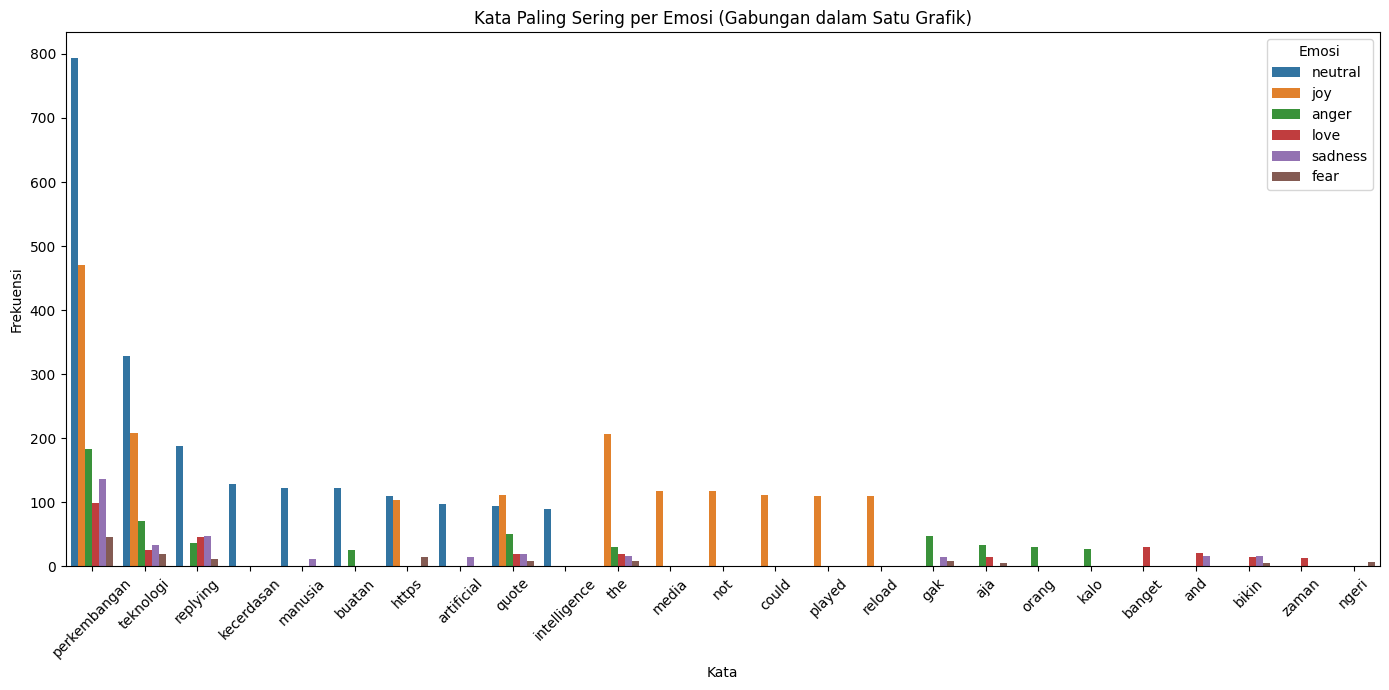

In [ ]:
# === Barplot Gabungan ===
plt.figure(figsize=(14, 7))
sns.barplot(data=word_freq_df, x='word', y='count', hue='predicted_label', dodge=True)
plt.title('Kata Paling Sering per Emosi (Gabungan dalam Satu Grafik)')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.legend(title='Emosi')
plt.tight_layout()
plt.show()


## 10. Analisis Perubahan Emosi Berdasarkan Waktu

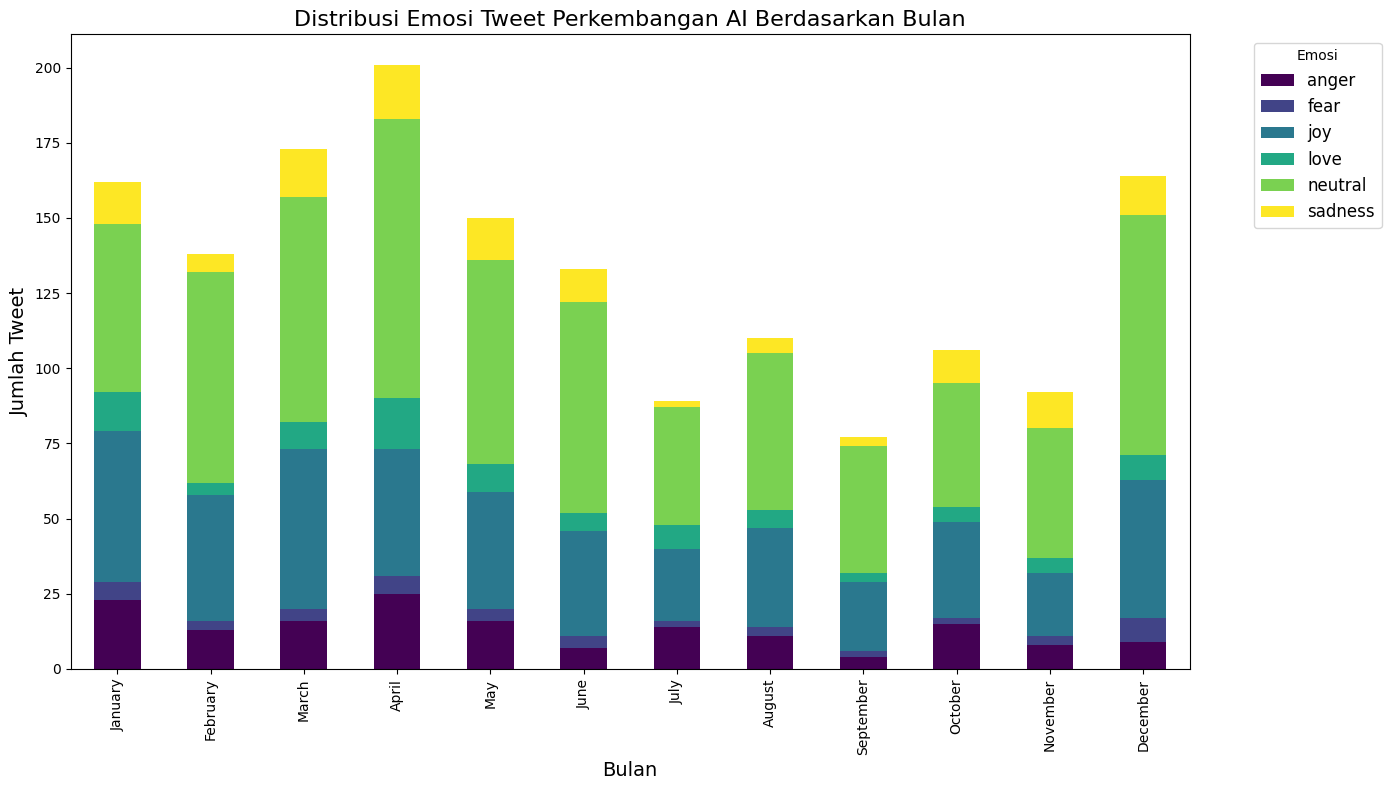

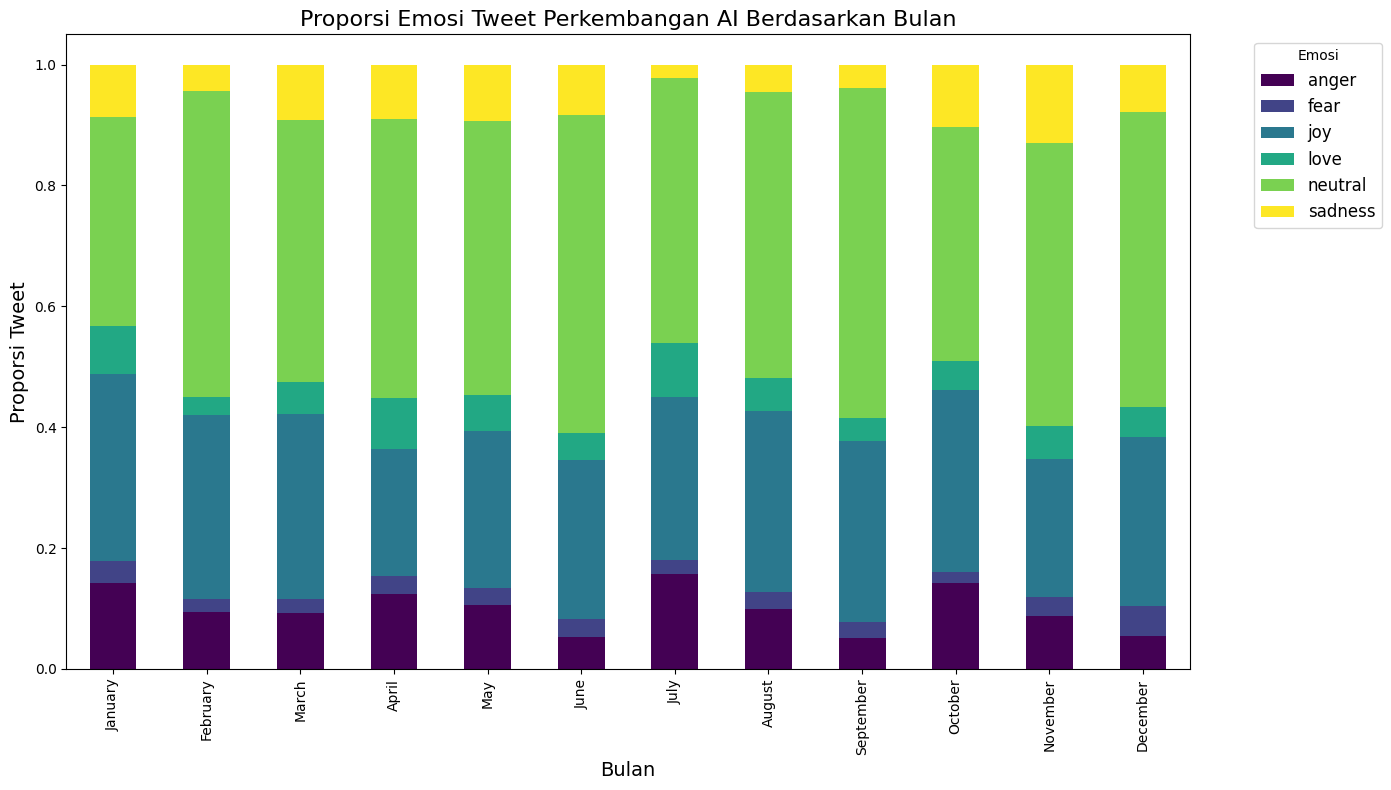

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_with_date = df.dropna(subset=['date'])
df_with_date['Month'] = df_with_date['date'].dt.month_name()
predicted_label_by_month = df_with_date.groupby(['Month', 'predicted_label']).size().unstack(fill_value=0)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
predicted_label_by_month = predicted_label_by_month.reindex(month_order)


plt.figure(figsize=(14, 8))
predicted_label_by_month.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Distribusi Emosi Tweet Perkembangan AI Berdasarkan Bulan', fontsize=16)
plt.xlabel('Bulan', fontsize=14)
plt.ylabel('Jumlah Tweet', fontsize=14)
plt.legend(title='Emosi', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

predicted_label_prop_by_month = predicted_label_by_month.div(predicted_label_by_month.sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
predicted_label_prop_by_month.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Proporsi Emosi Tweet Perkembangan AI Berdasarkan Bulan', fontsize=16)
plt.xlabel('Bulan', fontsize=14)
plt.ylabel('Proporsi Tweet', fontsize=14)
plt.legend(title='Emosi', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Analisis Sentimen


📊 Distribusi Sentimen:
Sentiment
netral     729
positif    533
negatif    333
Name: count, dtype: int64


<ipython-input-44-3148047484>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=[colors.get(label, 'gray') for label in sentiment_counts.index])


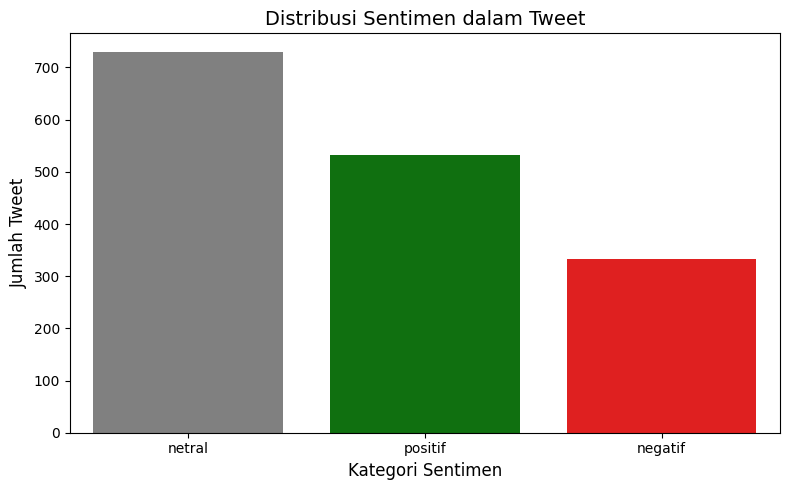

In [ ]:
def kategori_emosi(predicted_label):
    if predicted_label in ['joy', 'love']:
        return 'positif'
    elif predicted_label in ['sadness', 'anger', 'fear']:
        return 'negatif'
    else:
        return "netral"

# Aplikasikan fungsi kategori_emosi ke kolom 'predicted_label'
df['Sentiment'] = df['predicted_label'].apply(kategori_emosi)

# Tampilkan hasil value_counts untuk kolom 'Sentiment' yang baru
print("\n📊 Distribusi Sentimen:")
print(df['Sentiment'].value_counts())

# (Opsional) Simpan DataFrame dengan kolom Sentiment baru ke file CSV
# df.to_csv("df_with_sentiment.csv", index=False)

# Visualisasi Distribusi Sentimen
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
colors = {'positif': 'green', 'negatif': 'red', 'campuran': 'purple', None: 'gray'} # Tambahkan warna untuk None jika ada
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=[colors.get(label, 'gray') for label in sentiment_counts.index])
plt.title('Distribusi Sentimen dalam Tweet', fontsize=14)
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 7. Analisis Tren Berdasarkan Tanggal

In [ ]:

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Define 'year' and 'year_month' columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Define the 'years' variable by getting unique years from the DataFrame
years = sorted(df['year'].unique())

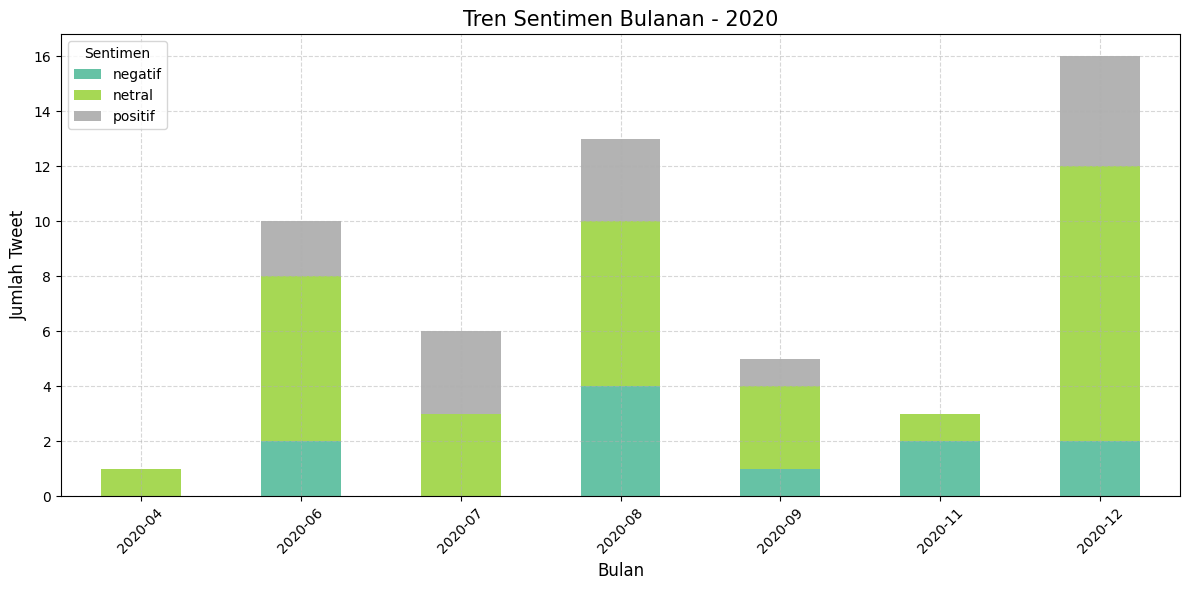

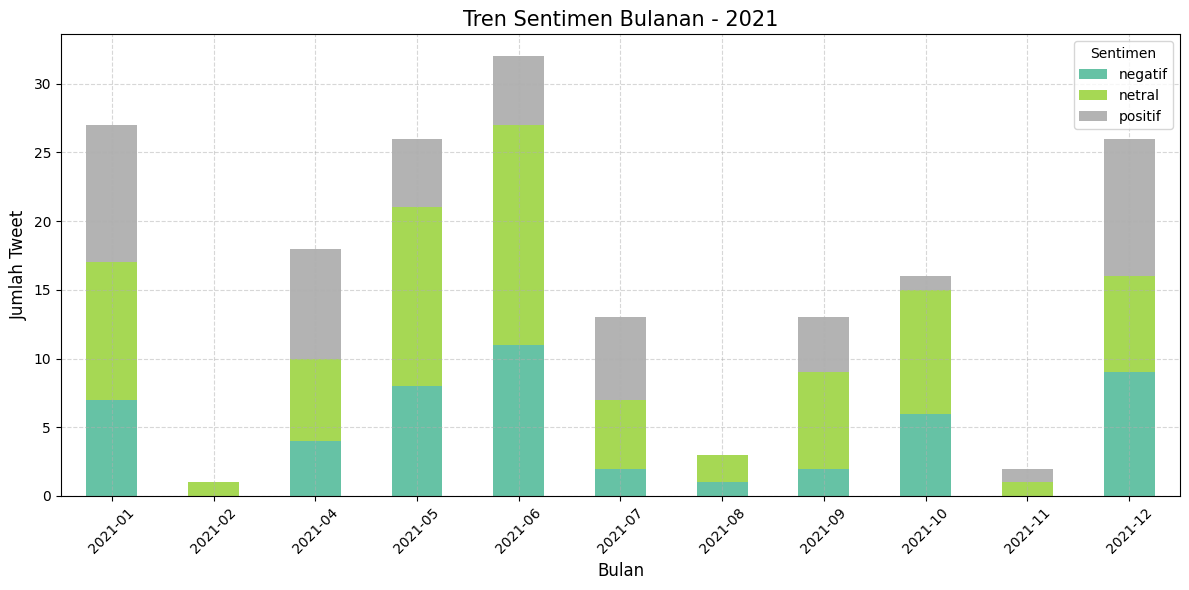

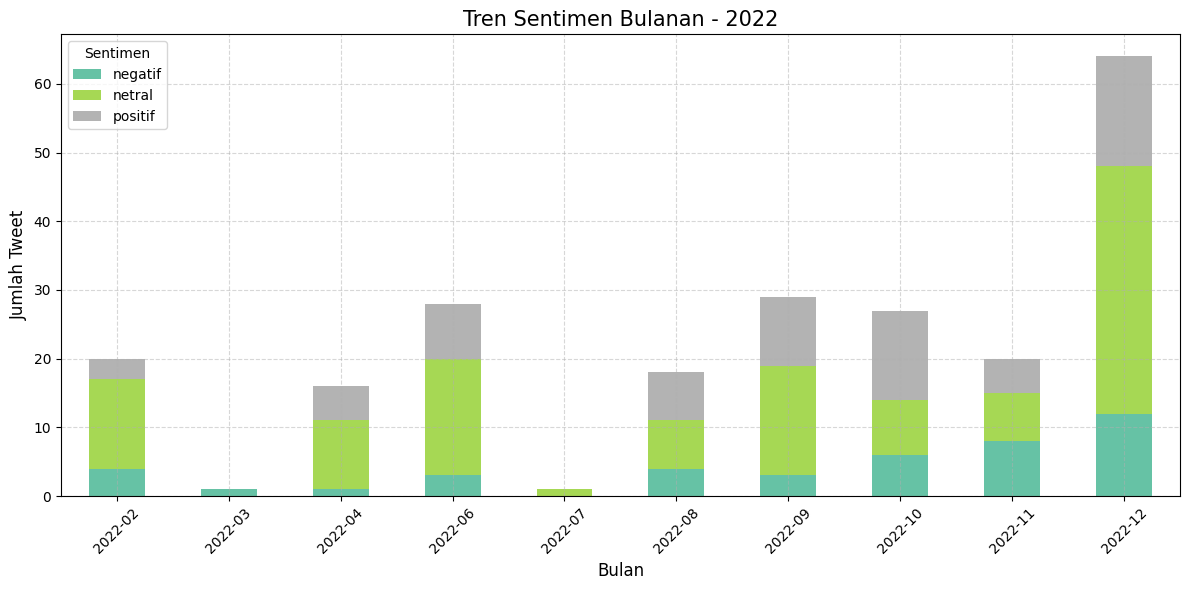

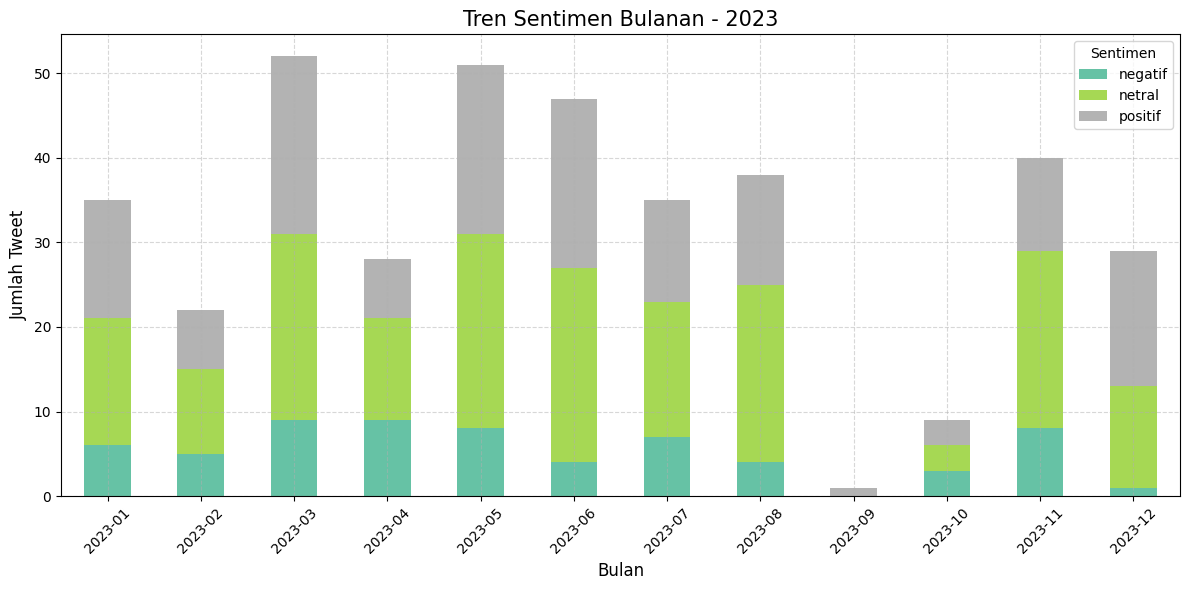

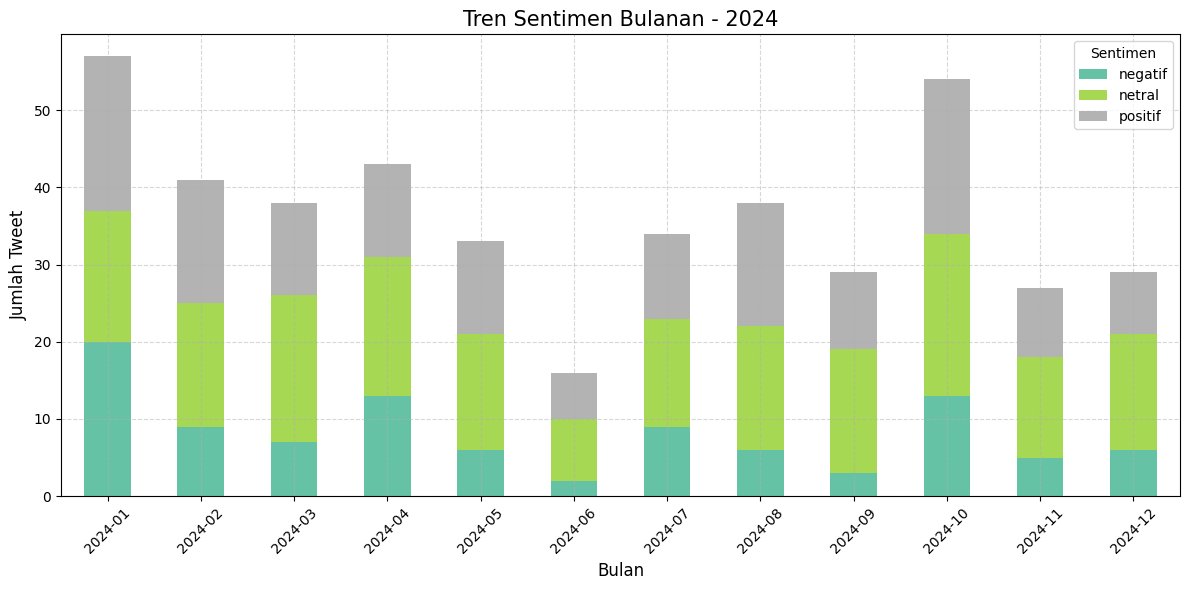

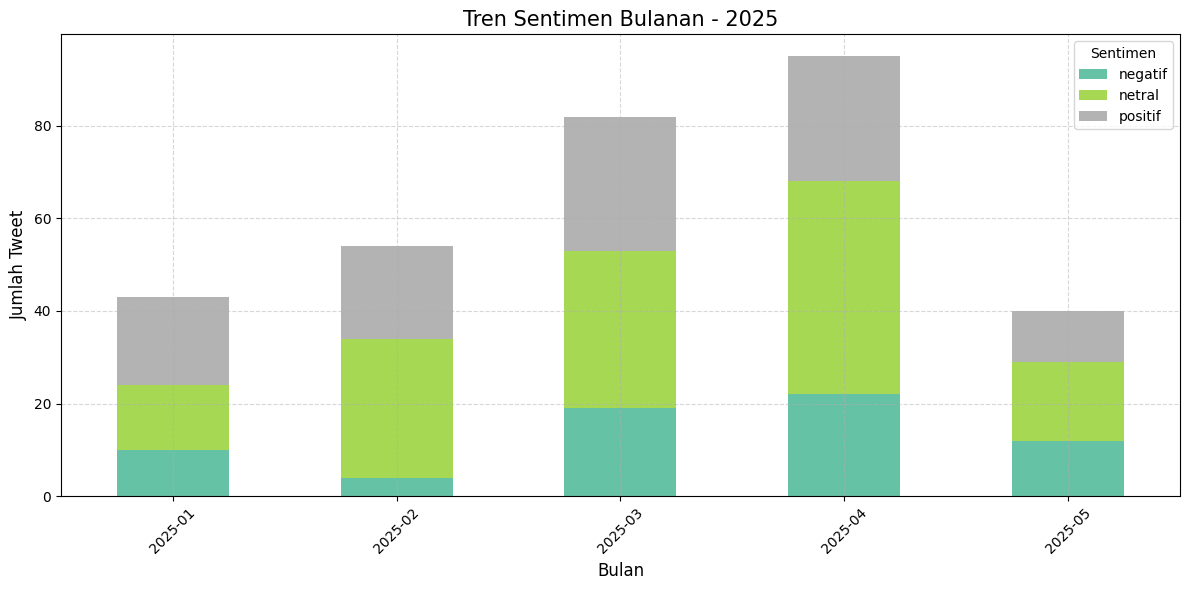

In [ ]:


for year in years:
    df_year = df[df['year'] == year]
    sentiment_by_month = df_year.groupby(['year_month', 'Sentiment']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 6))
    sentiment_by_month.plot(kind='bar', stacked=True, colormap='Set2', linewidth=1, ax=plt.gca())
    plt.title(f'Tren Sentimen Bulanan - {year}', fontsize=15)
    plt.xlabel('Bulan', fontsize=12)
    plt.ylabel('Jumlah Tweet', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.legend(title='Sentimen')
    plt.tight_layout()
    plt.show()

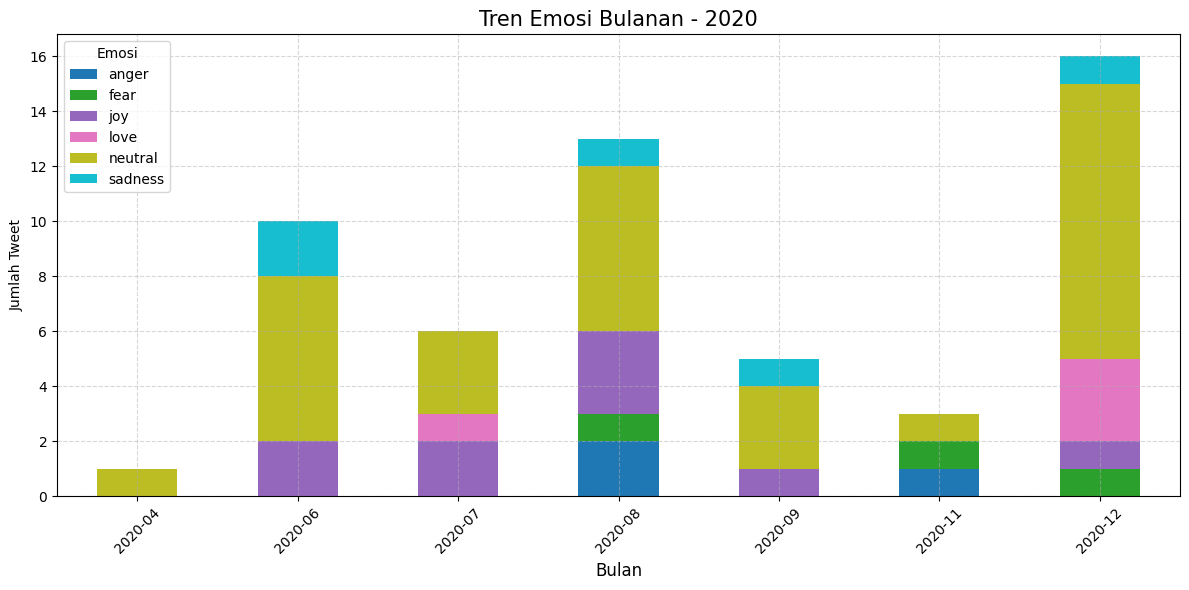

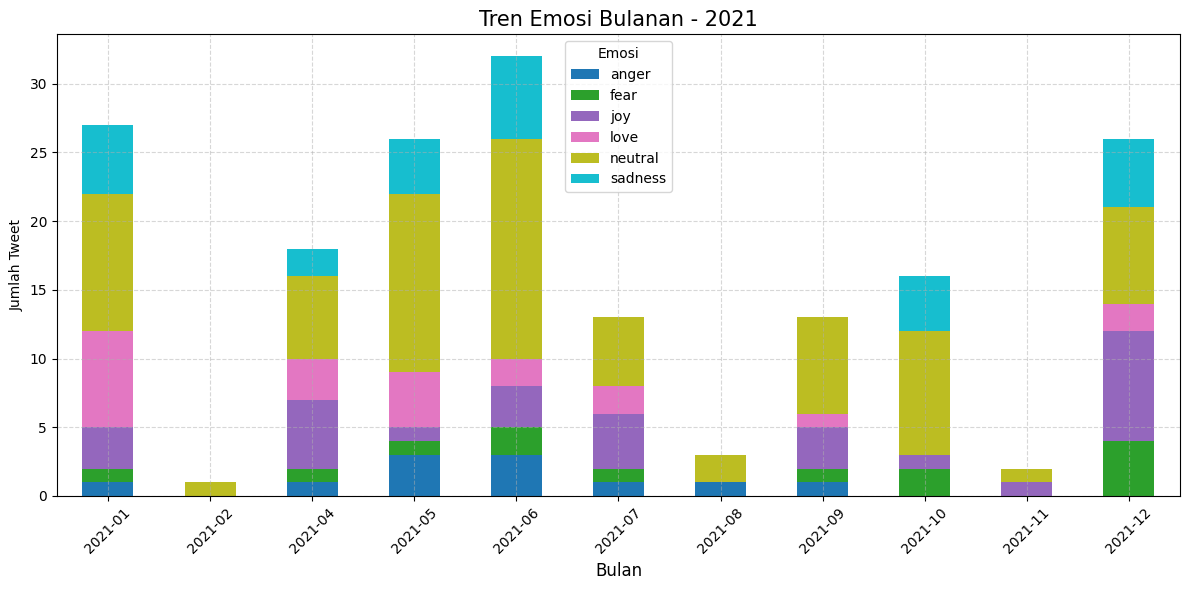

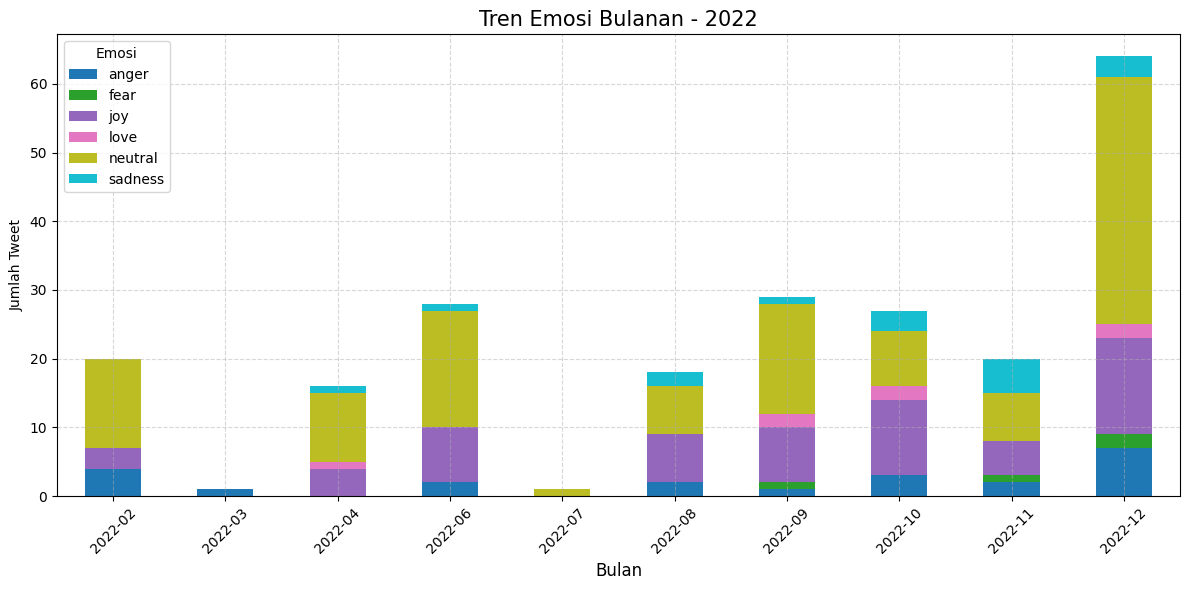

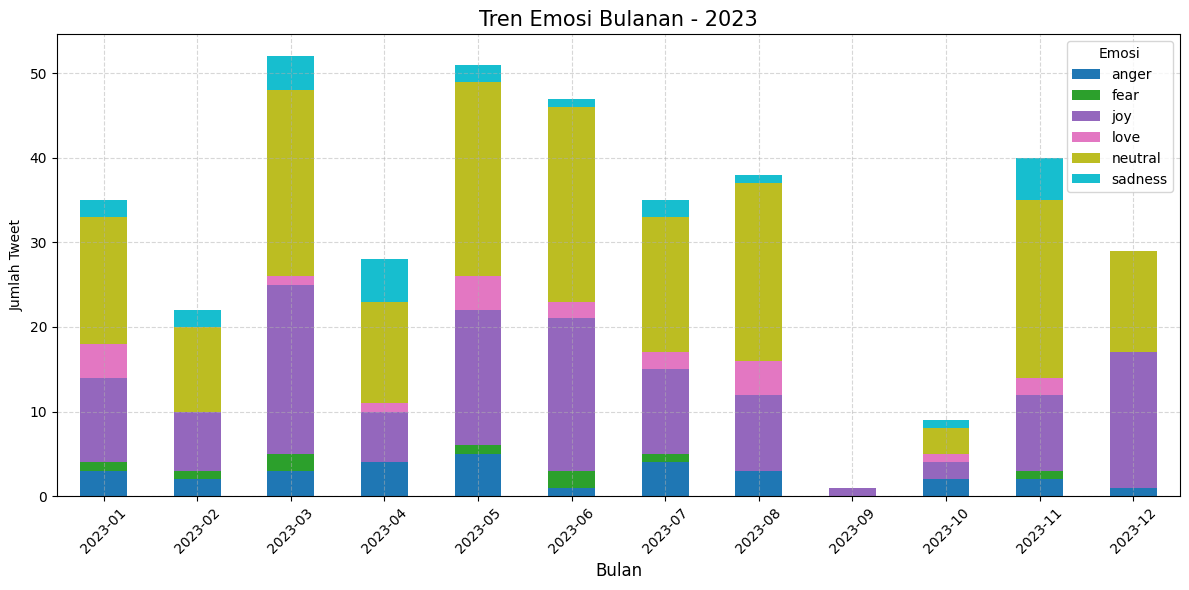

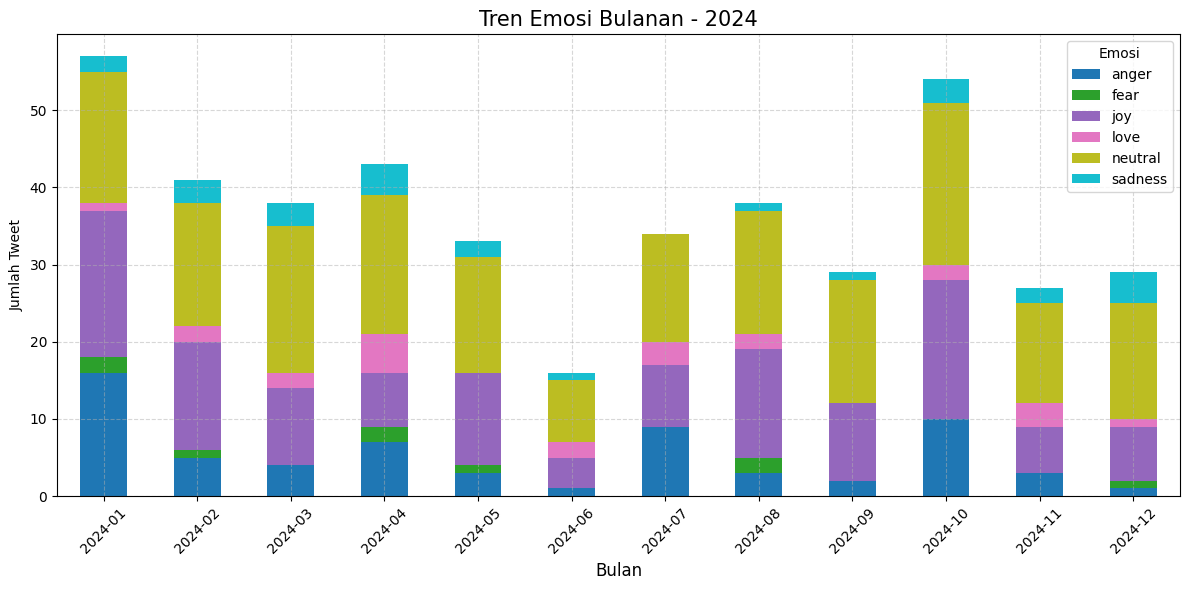

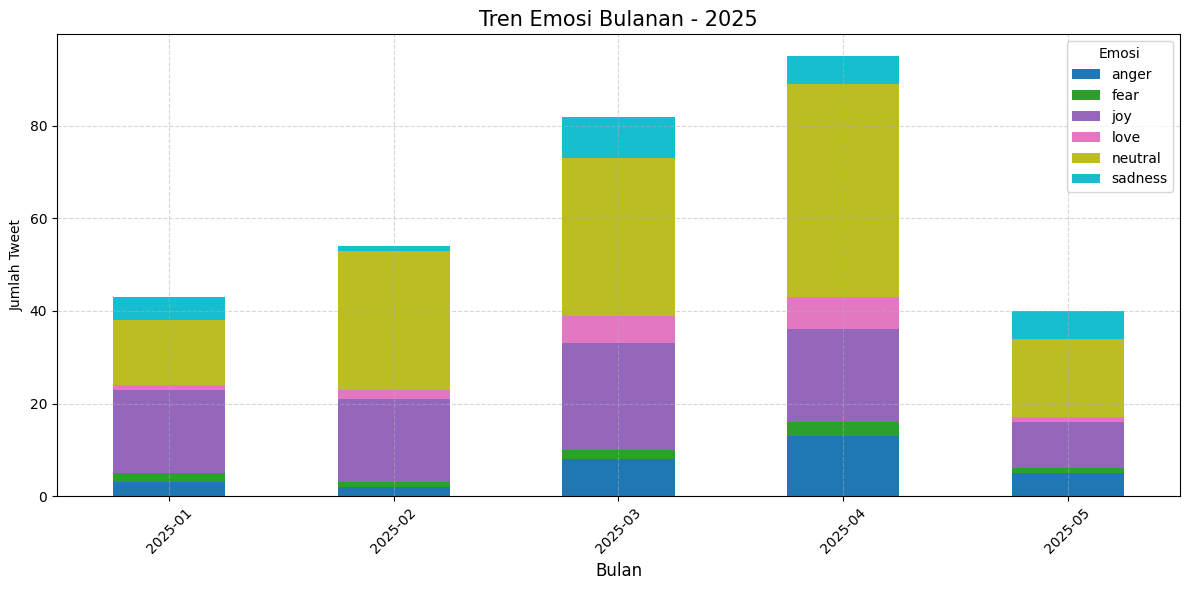

In [ ]:
for year in years:
    df_year = df[df['year'] == year]
    predicted_label_by_month = df_year.groupby(['year_month', 'predicted_label']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 6))
    predicted_label_by_month.plot(kind='bar', stacked=True, colormap='tab10', ax=plt.gca())
    plt.title(f'Tren Emosi Bulanan - {year}', fontsize=15)
    plt.xlabel('Bulan', fontsize=12)
    plt.ylabel('Jumlah Tweet')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Emosi')
    plt.tight_layout()
    plt.show()


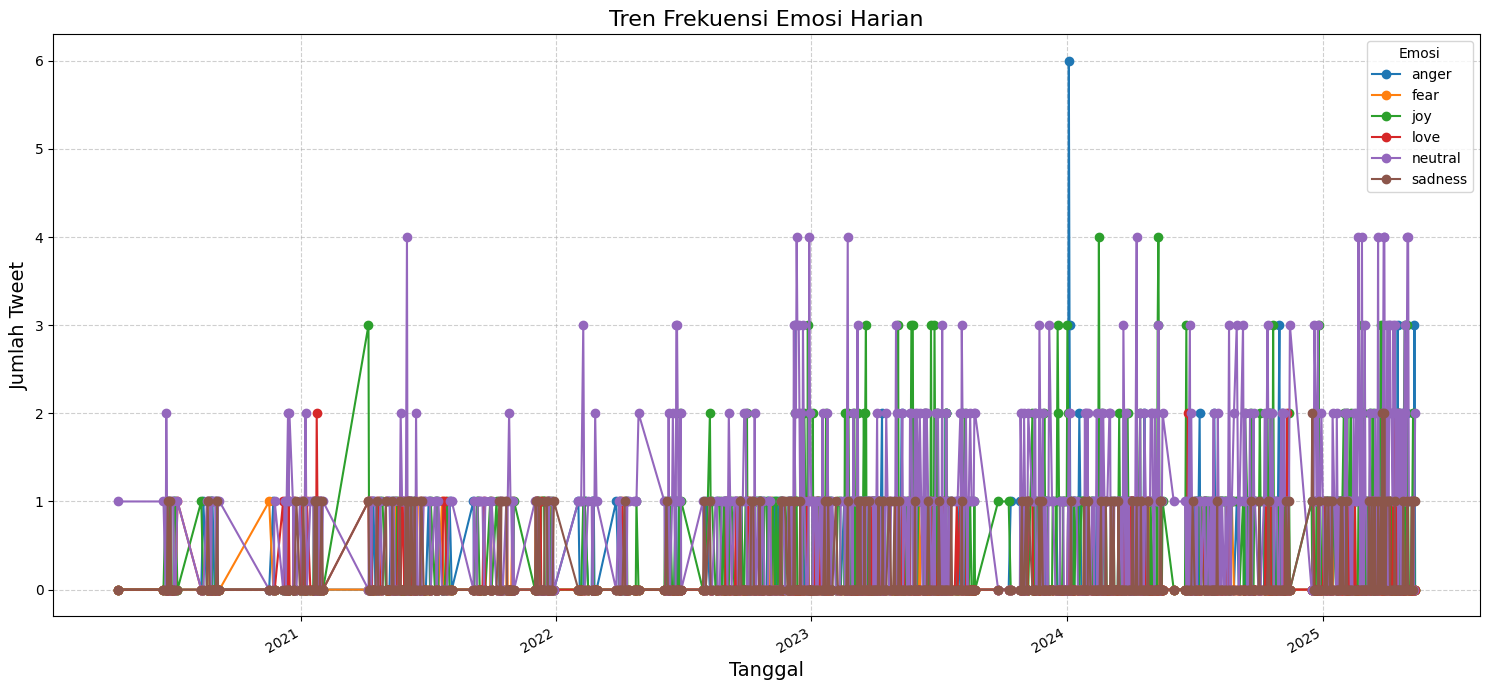

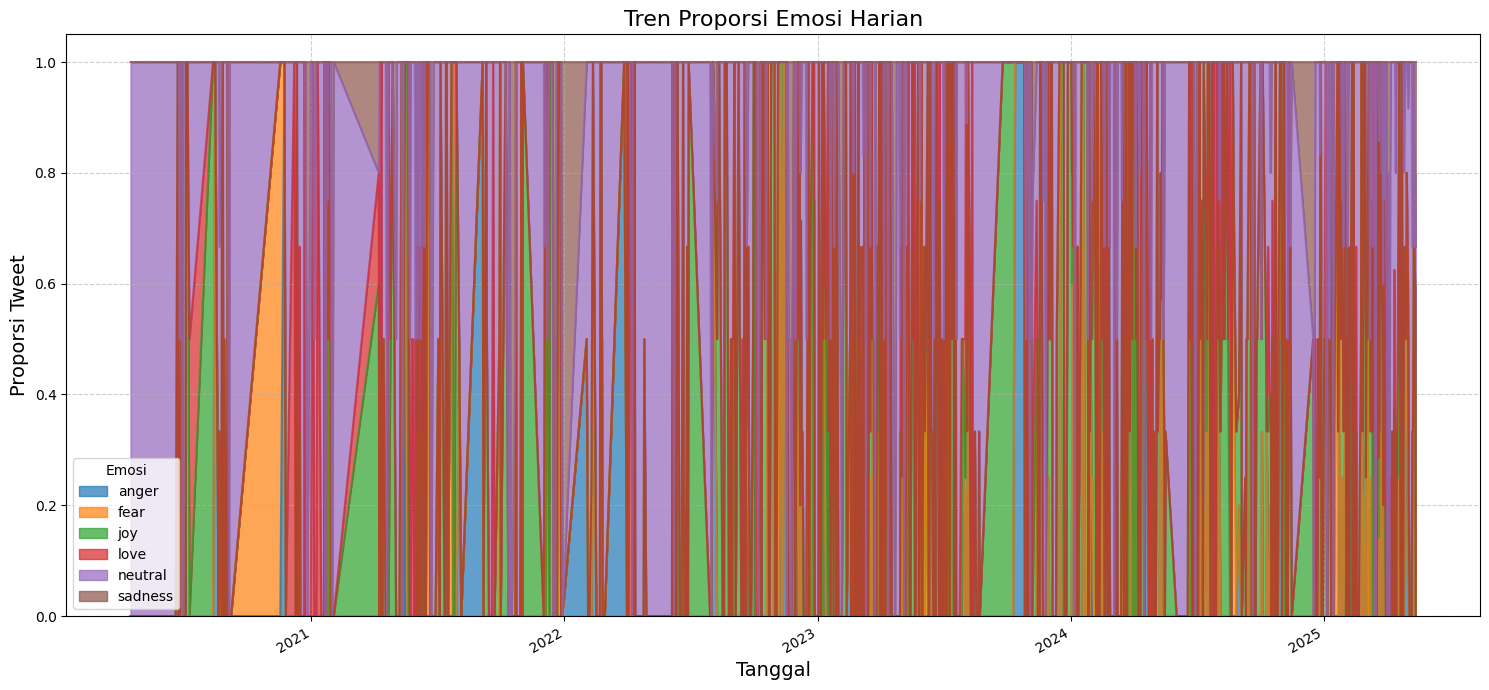